In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import skimage.color as sk_color
import glob
import matplotlib.pylab as plt

In [6]:
HOME_DIR = os.environ['HOME']
ROOT_DIR = HOME_DIR + '/kaggle/ds_bowl_2018'

DATA_DIR    = ROOT_DIR + '/input/'  
RESULTS_DIR = ROOT_DIR + '/results/'

/home/alex/kaggle/ds_bowl_2018


In [4]:
def read_list_from_file(list_file, comment='#', func=None):
    with open(list_file) as f:
        lines  = f.readlines()

    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    if func is not None:
        strings=[func(s) for s in strings]

    return strings

def thresh_to_inner_contour(mask):
    mask_pad = np.lib.pad(mask, ((1, 1), (1, 1)), 'reflect')
    contour = mask_pad[1:-1, 1:-1] & \
            ((mask_pad[1:-1, 1:-1] != mask_pad[:-2, 1:-1]) | (mask_pad[1:-1, 1:-1] != mask_pad[2:, 1:-1]) | \
             (mask_pad[1:-1, 1:-1] != mask_pad[1:-1, :-2]) | (mask_pad[1:-1, 1:-1] != mask_pad[1:-1, 2:]))
    return contour

def multi_mask_to_overlay(multi_mask):
    overlay = sk_color.label2rgb(multi_mask, bg_label=0, bg_color=(0, 0, 0))*255
    overlay = overlay.astype(np.uint8)
    return overlay

def image_show(name, image, resize=1):
    H, W = image.shape[0:2]
    #cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    plt.imshow(image)
    #plt.imshow(image.astype('float'))
    #cv2.resizeWindow(name, round(resize*W), round(resize*H))

In [5]:
countour_on_image = None
def run_make_annotation():
    global countour_on_image
    split = 'train1_ids_all_670'
    ids = read_list_from_file(DATA_DIR + '/split/' + split, comment='#')

    for i in range(len(ids[:1])):
        image_files = glob.glob(DATA_DIR + ids[i] + '/images/*.png')
        assert(len(image_files)==1)
        image_file=image_files[0]

        #----clear old -----------------------------
        if 1:
            for f in ['one_mask.png','one_countour_mask.png','one_countour_image.png','one_countour.png',
                      'overlap.png', 'one_center.png','/masks.npy', '/labels.npy',
                      '/countour_on_image.png', '/cut_mask.png', '/label.npy', '/mask.png','/overlay.png',
                      '/multi.npy','/multi.png',
                      '/instance.npy','/instance.png',
                      '/multi_instance.npy','/multi_instance.png',
                      ]:
                file = DATA_DIR + ids[i] + '/' + f
                if os.path.exists(file):
                    os.remove(file)
        #----clear old -----------------------------
        
        #image
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)

        H, W, C = image.shape
        multi_mask = np.zeros((H, W), np.int32)
        mask       = np.zeros((H, W), np.uint8)
        countour   = np.zeros((H, W), np.uint8)        

        mask_files = glob.glob(DATA_DIR + ids[i] + '/masks/*.png')
        mask_files.sort()
        for cc in range(len(mask_files)):
            mask_inst = cv2.imread(mask_files[cc], cv2.IMREAD_GRAYSCALE)
            mask_bin = mask_inst > 128
            index  = np.where(mask_bin)

            multi_mask[index]= cc+1
            mask  = np.logical_or(mask, mask_bin)
            countour = np.logical_or(countour, thresh_to_inner_contour(mask_bin))
            
        ## save and show -------------------------------------------
        countour_on_image = image.copy()
        countour_on_image = countour[:, :, np.newaxis]*np.array([0, 255, 0]) + (1-countour[:, :, np.newaxis])*countour_on_image

        countour_overlay  = countour*255
        mask_overlay  = mask*255
        multi_mask_overlay = multi_mask_to_overlay(multi_mask)

        
#         image_show('image',image)
#         image_show('mask', mask_overlay)
#         image_show('multi_mask',multi_mask_overlay)
#         image_show('countour',countour_overlay.astype('float'))
#         image_show('countour_on_image',countour_on_image.astype('float'))
        
        np.save(    DATA_DIR + ids[i] + '/multi_mask.npy', multi_mask)
        cv2.imwrite(DATA_DIR + ids[i] + '/multi_mask.png', multi_mask_overlay)
        cv2.imwrite(DATA_DIR + ids[i] + '/mask.png', mask_overlay)
        cv2.imwrite(DATA_DIR + ids[i] + '/countour.png', countour_overlay)
        cv2.imwrite(DATA_DIR + ids[i] + '/countour_on_image.png', countour_on_image)            

In [31]:
%%time
run_make_annotation()

CPU times: user 40.8 ms, sys: 4.02 ms, total: 44.8 ms
Wall time: 43.9 ms


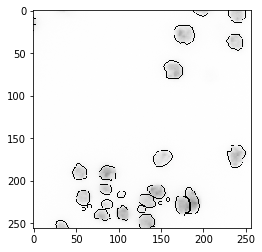

In [32]:
plt.imshow(countour_on_image.astype('float'))